# Hyperparameter Tuning with Optuna



With great models, comes the great problem of optimizing hyperparameters {cite}`AAAMLP`. Once a good search algorithm is established for hyperparameter optimization, the task becomes an engineering problem [^ref]. Hence, we will explore an open-source library that offers a framework for solving this task. 

[^ref]: Like all applied machine learning solutions.

```{figure} ../img/optuna.png
---
width: 25em
name: optuna
---
```

> **Optuna** is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, *define-by-run* style user API. Thanks to our *define-by-run* API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.


- [Optuna FAQ](https://optuna.readthedocs.io/en/stable/faq.html)
- [Optuna docs](https://optuna.readthedocs.io/en/stable/index.html#)
- [Optuna paper](https://arxiv.org/abs/1907.10902)

## Basics with scikit-learn

Optuna is a black-box optimizer, which means it only needs an objective function, which is any function that returns a numerical value, to evaluate the performance of the its parameters, and decide where to sample in upcoming trials. An optimization problem is framed in the Optuna API using two basic concepts: `study` and `trial`. 

A study is conceptually an optimization based on an objective function, while a trial is a single execution of an objective function. The combination of hyperparameters for each trial is sampled according to some sampling algorithm defined by the study. 

In the following code example, the search space is constructed within imperative Python code, e.g. inside conditionals or loops. On the other hand, recall that for `GridSearchCV` and `RandomSearchCV` in scikit-learn, we had to define the entire search space before running the search algorithm.

````{margin}
```{tip}
Always perform model evaluation on a dataset within a cross-validation framework!
```
````

In [ ]:
!pip install optuna
import optuna
import pandas as pd
from sklearn import ensemble, svm
from sklearn import datasets
from sklearn import model_selection
from functools import partial
import joblib


# [1] Define an objective function to be maximized.
def objective(trial, X, y):
    
    # [2] Suggest values for the hyperparameters using trial object.
    clf_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if clf_name == 'SVC':
        svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
        clf = svm.SVC(C=svc_c, gamma='auto')
    else:
        rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
        clf = ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)

    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()

# [3] Create a study object and optimize the objective function.
X, y = datasets.load_breast_cancer(return_X_y=True)
study = optuna.create_study(direction="maximize")
study.optimize(partial(objective, X=X, y=y), n_trials=5)

     |████████████████████████████████| 302 kB 5.3 MB/s 
     |████████████████████████████████| 208 kB 47.5 MB/s 
     |████████████████████████████████| 80 kB 9.0 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 144 kB 43.4 MB/s 
     |████████████████████████████████| 111 kB 57.0 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=f947121c655b70878501035318321913678424de3907ac3a82165dfe493b9116
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


[I 2021-09-23 18:35:02,488] A new study created in memory with name: no-name-f461ac73-40bc-492b-bb8c-4864ca99b83e
[I 2021-09-23 18:35:03,652] Trial 0 finished with value: 0.9508150908244062 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 6.509030505470388}. Best is trial 0 with value: 0.9508150908244062.
[I 2021-09-23 18:35:03,752] Trial 1 finished with value: 0.6274181027790716 and parameters: {'classifier': 'SVC', 'svc_c': 1449.4111764866836}. Best is trial 0 with value: 0.9508150908244062.
[I 2021-09-23 18:35:03,854] Trial 2 finished with value: 0.6274181027790716 and parameters: {'classifier': 'SVC', 'svc_c': 10299.635699270357}. Best is trial 0 with value: 0.9508150908244062.
[I 2021-09-23 18:35:03,976] Trial 3 finished with value: 0.9595559695699425 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 18.812277838603638}. Best is trial 3 with value: 0.9595559695699425.
[I 2021-09-23 18:35:04,094] Trial 4 finished with value: 0.9543549138332557 and paramet

The `study` object saves the result of evaluating the objective each trial &mdash; which is essentially some choice of hyperparameters to evaluate. In the above study, the problem of model selection is framed as a hyperparameter optimization problem. Here we choose between an SVM-based algorithm or Random Forest.

In [ ]:
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_rf_max_depth,params_svc_c,state
0,0,0.950815,2021-09-23 18:35:02.492833,2021-09-23 18:35:03.652200,0 days 00:00:01.159367,RandomForest,6.509031,NaN,COMPLETE
1,1,0.627418,2021-09-23 18:35:03.654568,2021-09-23 18:35:03.752128,0 days 00:00:00.097560,SVC,NaN,1449.411176,COMPLETE
2,2,0.627418,2021-09-23 18:35:03.754231,2021-09-23 18:35:03.854141,0 days 00:00:00.099910,SVC,NaN,10299.635699,COMPLETE
3,3,0.959556,2021-09-23 18:35:03.855947,2021-09-23 18:35:03.976102,0 days 00:00:00.120155,RandomForest,18.812278,NaN,COMPLETE
4,4,0.954355,2021-09-23 18:35:03.977696,2021-09-23 18:35:04.094330,0 days 00:00:00.116634,RandomForest,20.212303,NaN,COMPLETE


### Fine tuning Random Forest

Here we focus on tuning a single Random Forest model. Then, plot the accuracy for each pair of hyperparameters.

In [ ]:
def objective(trial):
    
    max_depth = trial.suggest_int('max_depth', 2, 128, log=True)    
    max_features = trial.suggest_float('max_features', 0.1, 1.0)    
    n_estimators = trial.suggest_int('n_estimators', 100, 800)
    
    clf = ensemble.RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        max_features=max_features,
        random_state=42)   
    
    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2)

[I 2021-09-23 18:33:19,832] A new study created in memory with name: no-name-2f595377-5fc5-42d4-8085-448f9dd84798
[I 2021-09-23 18:33:22,713] Trial 0 finished with value: 0.9613569321533924 and parameters: {'max_depth': 4, 'max_features': 0.445893253741384, 'n_estimators': 219}. Best is trial 0 with value: 0.9613569321533924.
[I 2021-09-23 18:33:24,072] Trial 1 finished with value: 0.9507995652848935 and parameters: {'max_depth': 2, 'max_features': 0.6021468363629987, 'n_estimators': 126}. Best is trial 0 with value: 0.9613569321533924.
[I 2021-09-23 18:33:34,350] Trial 2 finished with value: 0.95960254618848 and parameters: {'max_depth': 26, 'max_features': 0.46656457739077895, 'n_estimators': 793}. Best is trial 0 with value: 0.9613569321533924.
[I 2021-09-23 18:33:36,045] Trial 3 finished with value: 0.9666511411271541 and parameters: {'max_depth': 21, 'max_features': 0.5087501822102455, 'n_estimators': 116}. Best is trial 3 with value: 0.9666511411271541.
[I 2021-09-23 18:33:38,391

In [ ]:
study.best_params

{'max_depth': 21, 'max_features': 0.5087501822102455, 'n_estimators': 116}

In [ ]:
study.best_value

0.9666511411271541

### Sampling algorithms

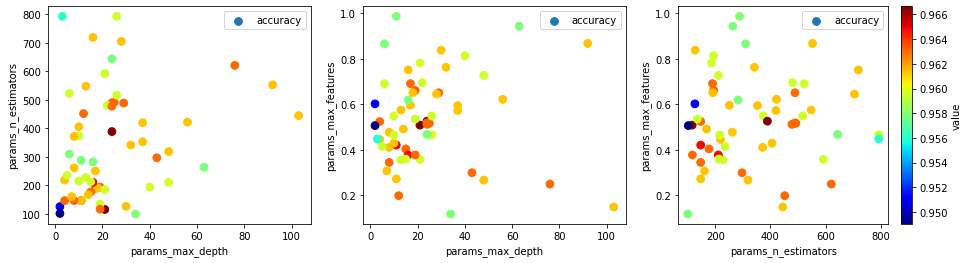

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3)

def plot_results(study, p1, p2, j, cb):
    study.trials_dataframe().plot(
        kind='scatter', ax=axes[j], x=p1, y=p2,
        c='value', s=60, cmap=plt.get_cmap("jet"), 
        colorbar=cb, label="accuracy", figsize=(16, 4)
    )

plot_results(study, 'params_max_depth',    'params_n_estimators', j=0, cb=False)
plot_results(study, 'params_max_depth',    'params_max_features', j=1, cb=False)
plot_results(study, 'params_n_estimators', 'params_max_features', j=2, cb=True);

**Figure.** TPE in action. Optuna uses  **Tree-structured Parzen Estimater (TPE)** {cite}`bergstra` as the default sampler which is a form of Bayesian optimization. Observe that the hyperparameter space is searched more efficiently than a random search with the sampler choosing points closer to previous good results. Samplers are specified when creating a study: 

```python
study = create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
```

From the [docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler):

> On each trial, for each parameter, TPE fits one Gaussian Mixture Model (GMM) `l(x)` to the set of parameter values associated with the best objective values, and another GMM `g(x)` to the remaining parameter values. It chooses the parameter value `x` that maximizes the ratio `l(x)/g(x)`.

Thus, TPE samples every hyperparameter **independently** &mdash; no explicit hyperparameter interactions are considered when sampling future trials, although other parameters implicitly affect objective value. Optuna also implements old friends random and grid search in the following samplers:
- `optuna.samplers.GridSampler`
- `optuna.samplers.RandomSampler`

Results from the [paper](https://arxiv.org/pdf/1907.10902.pdf) {cite}`akiba2019optuna`:

```{figure} ../img/fig9-optuna.png
---
width: 35em
name: fig9-optuna
---
```

```{figure} ../img/fig10-optuna.png
---
width: 35em
name: fig10-optuna
---
```

```{figure} ../img/optuna-results.png
---
width: 35em
name: optuna-results
---
```

<br>

<br>

**TPE+CMA-ES** sampling can be implemented as follows:

In [ ]:
sampler = optuna.samplers.CmaEsSampler(
    warn_independent_sampling=False,
    independent_sampler=optuna.samplers.TPESampler()
)

This uses the CMA-ES algorithm {cite}`hansen2016cma` with TPE for searching dynamically constructed hyperparameters (as CMA-ES requires that parameters are specified prior to the optimization). 

### Visualizations

Optuna provides visualization functions in the `optuna.visualization` library [^ref4]. The following plot shows the best objective value found as the trials progress. The increasing trend in accuracy indicates that the TPE sampler is working well, i.e. the search algorithm learns from previous trials.

[^ref4]: See [Optuna dashboard](https://github.com/optuna/optuna-dashboard) which displays the same plots that are updated in real-time.

In [8]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

The **parallel coordinate plot** gives us a feel of how the hyperparameters interact. For instance, `max_features` around 0.5 with `n_estimators` around 280 and `max_depth` around 20 generally perform well. This setting includes the best performing hyperparameters. To isolate subsets of lines, use the interactive capabilities of the plot below by dragging on each axis to restrict it. See {ref}`figure <optuna-restrict-rf>` immediately below.

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

```{figure} ../img/optuna-restrict-rf.png
---
name: optuna-restrict-rf
---
Using sliders to restrict values for certain parameters.
```

**Slice plots** project the path of the optimizer in the hyperparameter space on each dimension, then shift along the $y$-axis according on its objective value. A large spread of dark dots indicate that a large range of values of that hyperparameter is feasible even at later stages. Meanwhile, a small spread means that the sampler focuses on a small part of the search space &mdash; in this case, other hyperparameters implicitly improve the objective. For example, the parameter `max_features` is explored at a wide range even at later trials. Hence, we think of this feature as important. Indeed, the importance plot below supports this.

In [ ]:
optuna.visualization.plot_slice(study, params=['n_estimators', 'max_depth', 'max_features'])

By default, the **hyperparameter importance evaluator** in Optuna is `optuna.importance.FanovaImportanceEvaluator`. This takes as input performance data gathered with different hyperparameter settings of the algorithm, fits a random forest to capture the relationship between hyperparameters and performance, and then applies functional ANOVA to assess how important each of the hyperparameters and each low-order interaction of hyperparameters is to performance {cite}`pmlr-v32-hutter14`. From the [docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.importance.FanovaImportanceEvaluator.html):

> The performance of fANOVA depends on the prediction performance of the underlying random forest model. In order to obtain high prediction performance, it is necessary to cover a wide range of the hyperparameter search space. It is recommended to use an exploration-oriented sampler such as `RandomSampler`.

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(width=600, height=350)
fig.show()

To visualize interactions of any pair of hyperparameters, we use **contour plots.** The contour plots indicate regions of high and low objective value.

In [ ]:
fig = optuna.visualization.plot_contour(study, params=["max_depth", "max_features"])
fig.update_layout(width=550, height=500)
fig.show()

## Neural networks

As noted above, we should always perform tuning within a cross-validation framework. However, with neural networks, doing 5-fold CV would require too much compute time &mdash; hence, too much resources, e.g. GPU usage. Instead, we perform tuning on a hold-out validation set and hope for the best. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

from sklearn import model_selection
from sklearn.datasets import fetch_openml

from tqdm import tqdm
import optuna
import numpy as np

Define a simple network.

In [ ]:
class MLPClassifier(nn.Module):
    """
    Neural network with multiple hidden fully-connected layers with ReLU 
    activation and dropout.
    """
    
    def __init__(self, input_size, num_classes, n_layers, out_features, drop_rate):
        super().__init__()
        layers = []
        in_features = input_size
        for i in range(n_layers):

            m = nn.Linear(in_features, out_features[i])
            nn.init.kaiming_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

            layers.append(m)
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))

            in_features = out_features[i]

        layers.append(nn.Linear(in_features, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

We also define a `Dataset` class for MNIST.

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, features, targets, transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, i):
        X = self.features[i, :]
        y = self.targets[i]
        
        if self.transform is not None:
            X = self.transform(X)
            
        return X, y

Define a trainer for the neural network model. This will handle all loss and metric evaluation, as well as backpropagation.

In [ ]:
class Engine:
    """Neural network trainer."""
    
    def __init__(self, model, device, optimizer):
        self.model = model
        self.device = device
        self.optimizer = optimizer 

    @staticmethod
    def loss_fn(outputs, targets):
        return nn.CrossEntropyLoss()(outputs, targets)
        
    def train(self, data_loader):
        """Train model on one epoch. Return train loss."""
        
        self.model.train()
        loss = 0
        for i, (data, targets) in enumerate(data_loader):
            data = data.to(self.device).reshape(data.shape[0], -1).float()
            targets = targets.to(self.device).long()
            
            # Forward pass
            outputs = self.model(data)
            J = self.loss_fn(outputs, targets)
            
            # Backward pass
            self.optimizer.zero_grad()
            J.backward()
            self.optimizer.step()

            # Cumulative loss
            loss += (J.detach().item() - loss) / (i + 1)

        return loss


    def eval(self, data_loader):
        """Return validation loss and validation accuracy."""
        
        self.model.eval()
        num_correct = 0
        num_samples = 0
        loss = 0.0
        with torch.no_grad():
            for i, (data, targets) in enumerate(data_loader):
                data = data.to(self.device).float()
                targets = targets.to(self.device)
                
                # Forward pass
                data = data.reshape(data.shape[0], -1)
                out = self.model(data)
                J = self.loss_fn(out, targets)
                _, preds = out.max(dim=1)

                # Cumulative metrics
                loss += (J.detach().item() - loss) / (i + 1)
                num_correct += (preds == targets).sum().item()
                num_samples += preds.shape[0]

        acc = num_correct / num_samples
        return loss, acc

Some config and setup prior to training. For our dataset, we use MNIST which we get from scikit-learn.

In [ ]:
# Config
RANDOM_STATE = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 100
PATIENCE = 5
INPUT_SIZE = 784
NUM_CLASSES = 10

# Fetch data
MNIST = fetch_openml("mnist_784")
X = MNIST['data'].reshape(-1, 28, 28)
y = MNIST['target'].astype(int)

# Create folds
cv = model_selection.StratifiedKFold(n_splits=5)
trn_, val_ = next(iter(cv.split(X=X, y=y)))

# Get train and valid data loaders
train_dataset = MNISTDataset(X[trn_, :], y[trn_], transform=transforms.ToTensor())
valid_dataset = MNISTDataset(X[val_, :], y[val_], transform=transforms.ToTensor())

### Intermediate values

Finally, we set up the `study` instance and its objective function. Note that the search space is dynamically constructed depending on the number of layers (i.e. an earlier suggestion for a hyperparameter). During training, we perform early stopping on validation loss. If no new minimum val. loss is found after 5 epochs, then the minimum val. loss is returned as the objective [^ref3].

Computing intermediate values allow us to **prune** unpromising trials to conserve resources. The default pruner in Optuna is [`optuna.pruners.MedianPruner`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.MedianPruner.html) which prunes a trial if its best intermediate result as of the current step (e.g. current best valid loss) is worse than the median of all intermediate results of previous trials *at the current step*. Hence, the best intermediate result of a pruned trial is less than the best intermediate result of 1/2 of the other trials as of that step. In our case, if the minimum val. loss does not improve too quickly, then the trial is pruned. Of course, the validation loss could descend rapidly at later steps, but the median pruner does not bet on this happening.

[^ref3]: In practice, we save the best model parameters at this point.

In [ ]:
def define_model(trial):
  
    # Optimize the # of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    out_features = []
    drop_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    for i in range(n_layers):
        out_features.append(trial.suggest_int("n_units_l{}".format(i), 4, 128))

    return MLPClassifier(INPUT_SIZE, NUM_CLASSES, n_layers, out_features, drop_rate)


def objective(trial):

    model = define_model(trial).to(DEVICE)
    batch_size = trial.suggest_int('batch_size', 8, 512, log=True)
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.5)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)
    engine = Engine(model, DEVICE, optimizer)

    # Init. dataloaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
    
    # Run training
    best_loss = np.inf
    patience = PATIENCE
    for epoch in tqdm(range(EPOCHS), total=EPOCHS, leave=False):

        # Train and validation step
        train_loss = engine.train(train_loader)
        valid_loss, valid_acc = engine.eval(valid_loader)

        # Reduce learning rate
        if scheduler is not None:
            scheduler.step(valid_loss)
            
        # Early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = PATIENCE
        else:
            patience -= 1
            if patience == 0:
                break
    
        # Pruning unpromising trials
        trial.report(valid_loss, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_loss

# Create and run optimization problem 
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60)

In [ ]:
from optuna.trial import TrialState

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials:\t", len(study.trials))
print("  Number of pruned trials:\t", len(pruned_trials))
print("  Number of complete trials:\t", len(complete_trials))

print("\nBest trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Trials below either early stops (gradient descent loses momentum) or gets pruned (unlikely to improve even if gradient descent continues). Note that pruning starts at Trial 5. This can be tweaked in the `n_startup_trials=5` parameter of the pruner. In this case, pruning is disabled until the 5 trials finish in the same study. This is so that the pruner obtains enough information about the behavior of the gradient descent optimizer before starting to prune. 

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

### Hyperparameter interactions

We look at which combinations of hyperparameters work well from the parallel coordinate plot. Note that there is something weird going on here. For example, trials with `n_layers=1` has coordinates in axes where they should have no values, e.g. `n_units_l1` and `n_units_l2`. This is a known issue for parallel plots, e.g. [#1809](https://github.com/optuna/optuna/issues/1809). Turns out, lines with dynamically constructed parameters with NaNs should be skipped by plotter. Moreover, trials with NaN values are excluded from the parameter importance computation which limits its usefulness. 

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
study.trials_dataframe().head()

In [ ]:
study.trials_dataframe().query("state=='COMPLETE'").params_n_layers.value_counts()

Instead, we can look at each subset of trials for different values of `n_layers`. The resulting trials have no NaN parameters since the paramaters are sampled after a value for `n_layers` has been suggested. Looks like `n_layers=1` works best.

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Isolate a study for each value of n_layers
studies = [optuna.create_study() for j in range(3)]
for j in range(3):
    studies[j].add_trials([t for t in study.trials if t.params['n_layers'] == j+1])
    fig = optuna.visualization.plot_parallel_coordinate(studies[j])
    fig.show()

From the following contour plot, we see that a low batch size is generally good, with high values of dropout, learning rate, and weight decay, and only a single hidden layer. From the above parallel plot, a hidden layer of size around 90 looks good. 

In [ ]:
fig = optuna.visualization.plot_contour(study, params=['batch_size', 'lr', 'n_layers', 'weight_decay', 'dropout_rate'])
fig.update_layout(autosize=False, width=1200, height=1200)
fig.show()

## Appendix: Hyperparameters of commonly used models

<br>

```{figure} ../img/hyp.png
---
name: hyp
---
Table from p. 184 of {cite}`AAAMLP`. **RS**$^*$ implies random search should be better.
```